In [41]:
!pip install torch torchvision transformers opencv-python scikit-learn

In [42]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


In [43]:
# Define the transformations for the images
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
from torchvision import transforms
from PIL import Image
import os

# Load the CSV file
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTyh006zrmSWoKAwqF92kZ4lvNRKsZL5NYIkdSEK3wtrWA8yMKLT6K3h1k1nyyHjG9ntZvc9tTcbUif/pub?output=csv'
df = pd.read_csv(url,encoding="utf-8")

# Verify column names
print(df.columns)

# Drop unnecessary columns if they exist
columns_to_drop = [col for col in ['level', 'Unnamed: 5'] if col in df.columns]
df = df.drop(columns_to_drop, axis=1)

# Shuffle the dataframe
df = shuffle(df, random_state=42)

# Split the dataset
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

train_data, val_test = train_test_split(df, train_size=train_ratio, random_state=42)
valid_data, test_data = train_test_split(val_test, train_size=val_ratio / (val_ratio + test_ratio), random_state=42)

Index([' id', 'caption', 'label', 'level', 'area', 'Unnamed: 5'], dtype='object')


In [45]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Dataset class
class ImageDataset(Dataset):
    def __init__(self, dataframe, images_folder, image_transforms):
        # Filter out 'non informative' rows
        self.dataframe = dataframe[dataframe['label'].str.lower().str.strip() != 'non informative'].reset_index(drop=True)
        self.images_folder = images_folder
        self.image_transforms = image_transforms

        self.class_to_index = {
            'flood': 0,
            'cyclone': 1,
            'earthquake': 2,
            'river erosion': 3,
            'fire' : 4,
            'anthropogenic': 5
        }

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        label = row['label']
        image_id = str(row[' id']).strip()  # Adjust key if needed

        # Convert string label to int
        if isinstance(label, str):
            label = self.class_to_index[label.lower().strip()]
        else:
            label = int(label)

        # Check file extensions
        image_path_jpg = os.path.join(self.images_folder, f"{image_id}.jpg")
        image_path_png = os.path.join(self.images_folder, f"{image_id}.png")
        image_path_jpeg = os.path.join(self.images_folder, f"{image_id}.jpeg")

        if os.path.exists(image_path_jpg):
            image_path = image_path_jpg
        elif os.path.exists(image_path_png):
            image_path = image_path_png
        elif os.path.exists(image_path_jpeg):
            image_path = image_path_jpeg
        else:
            raise FileNotFoundError(f"Image {image_id} not found with .jpg, .png or .jpeg extension")

        image = Image.open(image_path).convert('RGB')
        image = self.image_transforms(image)

        assert 0 <= label <= 5, f"Label {label} out of range"

        return {
            'original_label': label,
            'pixel_values': image,
            'label': torch.tensor(label, dtype=torch.long)
        }

# Utility to show image
def imshow(image, ax=None, title=None, normalize=False):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))
    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
    ax.imshow(image)
    if title is not None:
        ax.set_title(title)
    ax.axis('off')
    return ax

# Utility to print samples
def print_samples(dataloader, num_samples=5):
    count = 0
    for batch in dataloader:
        if count >= num_samples:
            break
        for i in range(len(batch['pixel_values'])):
            if count >= num_samples:
                break
            print(f"Sample {count+1}:")
            print(f"Original Label: {batch['original_label'][i]}")
            imshow(batch['pixel_values'][i], normalize=True)
            plt.show()
            print()
            count += 1

In [46]:
# Data augmentation and normalization transforms
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

valid_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [47]:
# Paths
images_folder = '/kaggle/input/mddb-images/Photos_Final'

# Dataset and loaders (make sure train_data, valid_data, test_data DataFrames exist)
train_dataset = ImageDataset(train_data, images_folder, train_transforms)
valid_dataset = ImageDataset(valid_data, images_folder, valid_transforms)
test_dataset = ImageDataset(test_data, images_folder, valid_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


In [48]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing

    def forward(self, pred, target):
        confidence = 1.0 - self.smoothing
        log_probs = torch.nn.functional.log_softmax(pred, dim=-1)
        nll_loss = -log_probs.gather(dim=-1, index=target.unsqueeze(1)).squeeze(1)
        smooth_loss = -log_probs.mean(dim=-1)
        loss = confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()  # ← make sure this is here


In [49]:
# Model setup
# Load DenseNet121 with pretrained weights

from torch.optim.lr_scheduler import ReduceLROnPlateau

model = models.efficientnet_b0(pretrained=True)
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 6)  # 5 classes

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-4)
criterion = LabelSmoothingCrossEntropy(smoothing=0.1)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)


# Training function
def train_one_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0

    for batch in data_loader:
        optimizer.zero_grad()
        inputs = batch['pixel_values'].to(device)
        labels = batch['label'].to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_acc = correct_predictions.double() / len(data_loader.dataset)
    return epoch_loss, epoch_acc

# Validation function
def validate_one_epoch(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch['pixel_values'].to(device)
            labels = batch['label'].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_acc = correct_predictions.double() / len(data_loader.dataset)
    return epoch_loss, epoch_acc
    

# Early stopping parameters
num_epochs = 25
best_acc = 0.0
patience = 4
counter = 0

# Lists to save loss and accuracy for plotting
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

# Training loop
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    valid_loss, valid_acc = validate_one_epoch(model, valid_loader, criterion, device)

    scheduler.step(valid_loss)  

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_acc.item())
    valid_accuracies.append(valid_acc.item())

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
    print(f'Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc:.4f}')

    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save(model.state_dict(), 'best_model.pth')
        counter = 0
        print(f'Validation accuracy improved to {best_acc:.4f}. Model saved.')
    else:
        counter += 1
        print(f'No improvement for {counter} epoch(s)')

    if counter >= patience:
        print(f'Early stopping triggered after {patience} epochs with no improvement.')
        break

print('Training complete')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/25
Train Loss: 1.7773 | Train Acc: 0.2114
Valid Loss: 1.7104 | Valid Acc: 0.3360
Validation accuracy improved to 0.3360. Model saved.
Epoch 2/25
Train Loss: 1.7073 | Train Acc: 0.3295
Valid Loss: 1.6307 | Valid Acc: 0.4528
Validation accuracy improved to 0.4528. Model saved.
Epoch 3/25
Train Loss: 1.6227 | Train Acc: 0.4360
Valid Loss: 1.5560 | Valid Acc: 0.5104
Validation accuracy improved to 0.5104. Model saved.
Epoch 4/25
Train Loss: 1.5483 | Train Acc: 0.4979
Valid Loss: 1.4780 | Valid Acc: 0.5536
Validation accuracy improved to 0.5536. Model saved.
Epoch 5/25
Train Loss: 1.4741 | Train Acc: 0.5383
Valid Loss: 1.4029 | Valid Acc: 0.5840
Validation accuracy improved to 0.5840. Model saved.
Epoch 6/25
Train Loss: 1.3999 | Train Acc: 0.5687
Valid Loss: 1.3446 | Valid Acc: 0.5904
Validation accuracy improved to 0.5904. Model saved.
Epoch 7/25
Train Loss: 1.3500 | Train Acc: 0.5892
Valid Loss: 1.2923 | Valid Acc: 0.6032
Validation accuracy improved to 0.6032. Model saved.
Epoch 

<ipython-input-50-cc2d7045082f>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Accuracy: 0.7732
Precision: 0.7739
Recall: 0.7732
F1 Score: 0.7714

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.86      0.81       116
           1       0.76      0.61      0.68       101
           2       0.80      0.76      0.78       108
           3       0.79      0.75      0.77        92
           4       0.84      0.88      0.86        98
           5       0.71      0.77      0.74       120

    accuracy                           0.77       635
   macro avg       0.78      0.77      0.77       635
weighted avg       0.77      0.77      0.77       635



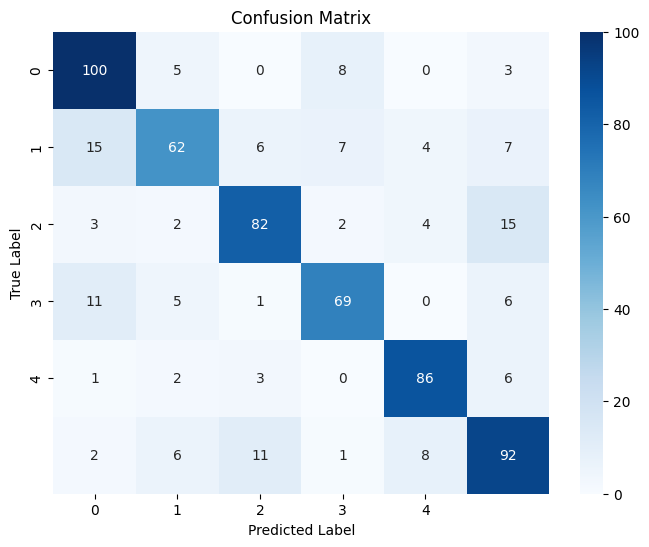

In [50]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Load best model
model.load_state_dict(torch.load('best_model.pth'))

# Predictions
def predict(model, data_loader, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in data_loader:
            inputs = batch['pixel_values'].to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
    return predictions

test_predictions = predict(model, test_loader, device)

# Evaluation
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            inputs = batch['pixel_values'].to(device)
            labels = batch['label'].to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    report = classification_report(all_labels, all_preds)

    return accuracy, precision, recall, f1, report, all_labels, all_preds

accuracy, precision, recall, f1, report, all_labels, all_preds = evaluate_model(model, test_loader, device)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(report)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(5), yticklabels=range(5))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


📉 Epoch-wise Losses:
Epoch  1: Train Loss = 1.7773, Val Loss = 1.7104
Epoch  2: Train Loss = 1.7073, Val Loss = 1.6307
Epoch  3: Train Loss = 1.6227, Val Loss = 1.5560
Epoch  4: Train Loss = 1.5483, Val Loss = 1.4780
Epoch  5: Train Loss = 1.4741, Val Loss = 1.4029
Epoch  6: Train Loss = 1.3999, Val Loss = 1.3446
Epoch  7: Train Loss = 1.3500, Val Loss = 1.2923
Epoch  8: Train Loss = 1.2936, Val Loss = 1.2458
Epoch  9: Train Loss = 1.2541, Val Loss = 1.2124
Epoch 10: Train Loss = 1.2164, Val Loss = 1.1856
Epoch 11: Train Loss = 1.1890, Val Loss = 1.1549
Epoch 12: Train Loss = 1.1424, Val Loss = 1.1377
Epoch 13: Train Loss = 1.1304, Val Loss = 1.1096
Epoch 14: Train Loss = 1.1095, Val Loss = 1.0940
Epoch 15: Train Loss = 1.0948, Val Loss = 1.0750
Epoch 16: Train Loss = 1.0801, Val Loss = 1.0641
Epoch 17: Train Loss = 1.0579, Val Loss = 1.0557
Epoch 18: Train Loss = 1.0340, Val Loss = 1.0461
Epoch 19: Train Loss = 1.0267, Val Loss = 1.0350
Epoch 20: Train Loss = 1.0173, Val Loss = 1.026

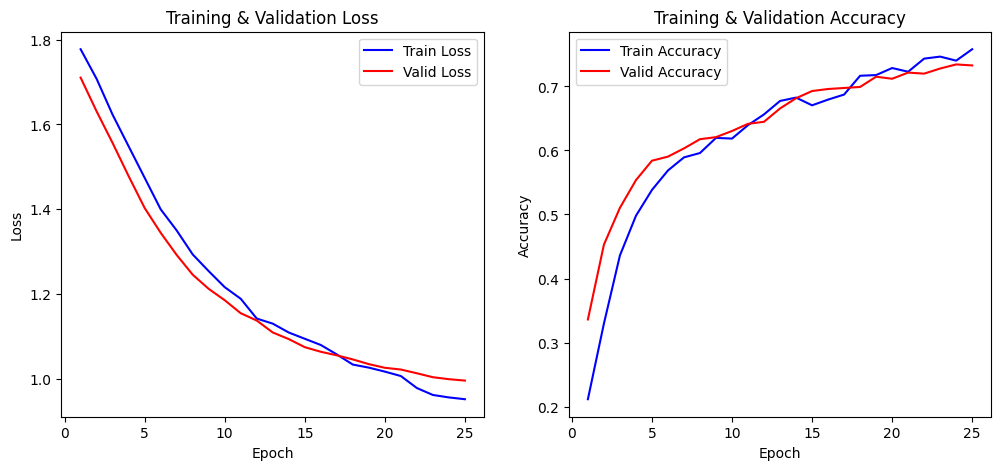

In [51]:

# Print epoch-wise losses
print("\n📉 Epoch-wise Losses:")
for i, (train, val) in enumerate(zip(train_losses, valid_losses), start=1):
    print(f"Epoch {i:2d}: Train Loss = {train:.4f}, Val Loss = {val:.4f}")

# Plot training & validation loss and accuracy curves
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Train Loss')
plt.plot(epochs, valid_losses, 'r-', label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b-', label='Train Accuracy')
plt.plot(epochs, valid_accuracies, 'r-', label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()